# UFO Analysis and Detection

## Functions

In [17]:
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Low-pass filtering the LFP or other time series data.
    
    Parameters
    ----------
    data : Tsd/TsdFrame
        The data to be filtered, expected to be an instance of Tsd or TsdFrame from the nap library.
    cutoff : float
        The cutoff frequency for the low-pass filter. Frequencies above this value will be attenuated.
    fs : float
        The sampling rate of the data (in Hz).
    order : int, optional
        The order of the filter. A higher order means a steeper roll-off. Default is 4.
    
    Returns
    -------
    filtered_data : Tsd/TsdFrame
        The filtered data, in the same format as the input data.
    
    Raises
    ------
    RuntimeError
        If the input data format is not supported (not Tsd or TsdFrame).
    """
    time_support = data.time_support
    time_index = data.as_units('s').index.values
    
    if type(data) is nap.TsdFrame:
        tmp = np.zeros(data.shape)
        for i in np.arange(data.shape[1]):
            tmp[:,i] = lowpass_filter(data[:,i], cutoff, fs, order).values

        return nap.TsdFrame(
            t = time_index,
            d = tmp,
            time_support = time_support,
            time_units = 's',
            columns = data.columns)

    elif type(data) is nap.Tsd:
        flfp = _butter_lowpass_filter(data.values, cutoff, fs, order)
        return nap.Tsd(
            t=time_index,
            d=flfp,
            time_support=time_support,
            time_units='s')

    else:
        raise RuntimeError("Unknown format. Should be Tsd/TsdFrame")

def _butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    Applies a Butterworth low-pass filter to the data.
    
    Parameters
    ----------
    data : array_like
        The input data to filter.
    cutoff : float
        The cutoff frequency for the low-pass filter.
    fs : float
        The sampling rate of the data (in Hz).
    order : int, optional
        The order of the filter.
    
    Returns
    -------
    y : ndarray
        The filtered output data.
    """
    from scipy.signal import butter, lfilter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y


In [18]:
def highpass_filter(data, cutoff, fs, order=4):
    """
    High-pass filtering the LFP or signal data.

    Parameters
    ----------
    data : Tsd/TsdFrame
        The data to be filtered. Can be a Time Series Data (Tsd) or Time Series Data Frame (TsdFrame).
    cutoff : float
        The cut-off frequency of the high-pass filter. Frequencies below this value will be attenuated.
    fs : float
        The sampling rate of the data, in Hz.
    order : int, optional
        The order of the filter. A higher order means a steeper drop-off. Default is 4.

    Raises
    ------
    RuntimeError
        Raised if the data format is not recognized (not Tsd or TsdFrame).

    Returns
    -------
    Tsd/TsdFrame
        The filtered data, in the same format as the input data.
    """
    time_support = data.time_support
    time_index = data.as_units('s').index.values

    if type(data) is nap.TsdFrame:
        tmp = np.zeros(data.shape)
        for i in np.arange(data.shape[1]):
            tmp[:, i] = highpass_filter(data[:, i], cutoff, fs, order).values

        return nap.TsdFrame(
            t=time_index,
            d=tmp,
            time_support=time_support,
            time_units='s',
            columns=data.columns)

    elif type(data) is nap.Tsd:
        fhfp = _butter_highpass_filter(data.values, cutoff, fs, order)
        return nap.Tsd(
            t=time_index,
            d=fhfp,
            time_support=time_support,
            time_units='s')

    else:
        raise RuntimeError("Unknown format. Should be Tsd/TsdFrame")

def _butter_highpass_filter(data, cutoff, fs, order=4):
    """
    Applies a Butterworth high-pass filter.

    Parameters
    ----------
    data : array_like
        The data to filter.
    cutoff : float
        The cut-off frequency of the filter.
    fs : float
        The sampling frequency of the data.
    order : int, optional
        The order of the filter.

    Returns
    -------
    filtered : array_like
        The filtered data.
    """
    from scipy.signal import butter, filtfilt
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered = filtfilt(b, a, data)
    return filtered


In [19]:
def fft_transform(data, fs):
    """
    Performs Fast Fourier Transform on the provided data.

    Parameters
    ----------
    data : Tsd/TsdFrame
        The data to be transformed. Can be a Time Series Data (Tsd) or Time Series Data Frame (TsdFrame).
    fs : float
        The sampling rate of the data, in Hz.

    Returns
    -------
    freqs : ndarray
        Array of sample frequencies.
    fft_values : ndarray or list of ndarray
        The FFT values corresponding to `freqs`. If `data` is a TsdFrame, `fft_values` will be a list where each element
        corresponds to a column in `data`.

    Raises
    ------
    RuntimeError
        Raised if the data format is not recognized (not Tsd or TsdFrame).
    """
    from numpy.fft import rfft, rfftfreq
    from numpy import abs as np_abs

    time_index = data.as_units('s').index.values

    if type(data) is nap.TsdFrame:
        fft_values = []
        freqs = rfftfreq(n=len(time_index), d=1/fs)
        for i in range(data.shape[1]):
            column_fft = np_abs(rfft(data[:, i].values))
            fft_values.append(column_fft)
        return freqs, fft_values

    elif type(data) is nap.Tsd:
        freqs = rfftfreq(n=len(time_index), d=1/fs)
        fft_values = np_abs(rfft(data.values))
        return freqs, fft_values

    else:
        raise RuntimeError("Unknown format. Should be Tsd/TsdFrame")


In [20]:
def stft_transform(data, fs, nperseg=256):
    """
    Performs Short-Time Fourier Transform on the provided data.

    Parameters
    ----------
    data : Tsd/TsdFrame
        The data to be transformed. Can be a Time Series Data (Tsd) or Time Series Data Frame (TsdFrame).
    fs : float
        The sampling rate of the data, in Hz.
    nperseg : int, optional
        The length of each segment for the STFT. Default is 256.

    Returns
    -------
    freqs : ndarray
        Array of sample frequencies.
    times : ndarray
        Array of segment times.
    stft_values : ndarray or list of ndarray
        The STFT values (complex-valued) corresponding to `freqs` and `times`. If `data` is a TsdFrame,
        `stft_values` will be a list where each element corresponds to a column in `data`.

    Raises
    ------
    RuntimeError
        Raised if the data format is not recognized (not Tsd or TsdFrame).
    """
    from scipy.signal import stft, get_window
    import numpy as np

    windowType = 'hann'
    overlapLength = nperseg//2
    window = get_window(windowType, nperseg)

    if type(data) is nap.TsdFrame:
        stft_values = []
        for i in range(data.shape[1]):
            f, t, Zxx = stft(data[:, i].values, fs, nperseg=nperseg, window=window, noverlap=overlapLength,  boundary='zeros', padded=True)
            Zxx_dB = np.log10(np.abs(Zxx)) * 20  # Convert to decibels
            
            stft_values.append(np.abs(Zxx))
        return f, t, stft_values

    elif type(data) is nap.Tsd:
        f, t, Zxx = stft(data.values, fs, nperseg=nperseg, window=window, noverlap=overlapLength,  boundary='zeros', padded=True)
        Zxx_dB = np.log10(np.abs(Zxx)) * 20  # Convert to decibels
        return f, t, np.abs(Zxx)

    else:
        raise RuntimeError("Unknown format. Should be Tsd/TsdFrame")


In [21]:
from scipy import signal, ndimage

def gaussian_spectrogram_transform(data, fs=20000, window_dur=0.005, step_dur=None, detrend=False, normalize=False):
    """
    Computes the Gaussian-windowed spectrogram of the provided data.

    Parameters
    ----------
    data : Tsd/TsdFrame
        The data to be transformed. Can be Time Series Data (Tsd) or Time Series Data Frame (TsdFrame).
    fs : float
        The sampling rate of the data, in Hz.
    window_dur : float, optional
        The duration of the Gaussian window in seconds. Default is 0.005.
    step_dur : float, optional
        The step duration in seconds. If None, it's automatically calculated. Default is None.
    detrend : bool, optional
        If True, detrend the data by removing the linear trend. Default is True.
    normalize : bool, optional
        If True, normalize the data by its standard deviation. Default is True.

    Returns
    -------
    freqs : ndarray
        Array of sample frequencies.
    times : ndarray
        Array of segment times.
    power_values : ndarray or list of ndarray
        The power spectral density values corresponding to `freqs` and `times`. If `data` is a TsdFrame,
        `power_values` will be a list where each element corresponds to a column in `data`.

    Raises
    ------
    RuntimeError
        Raised if the data format is not recognized (not Tsd or TsdFrame).
    """
    def compute_spectrogram(x,step_dur):
        if detrend:
            x = signal.detrend(x, type='linear')
        if normalize:
            stddev = x.std()
            x = x / stddev

        if step_dur is None:
            step_dur = window_dur / np.sqrt(np.pi) / 8.

        window_nsamp = int(window_dur * fs * 2)
        step_nsamp = int(step_dur * fs)

        window_sigma = (window_nsamp + 1) / 6
        window = signal.gaussian(window_nsamp, window_sigma)

        noverlap = window_nsamp - step_nsamp

        freqs, times, power = signal.spectrogram(x, detrend=False, mode='psd', fs=fs,
                                                 scaling='spectrum', noverlap=noverlap,
                                                 window=window, nperseg=window_nsamp)
        #power = ndimage.gaussian_filter(power, sigma=2)

        return power, times, freqs

    if hasattr(data, 'shape') and len(data.shape) == 2:  # TsdFrame
        power_values = []
        for i in range(data.shape[1]):
            power, times, freqs = compute_spectrogram(data[:, i].values,step_dur)
            power_values.append(power)
        return freqs, times, power_values

    elif hasattr(data, 'values'):  # Tsd
        power, times, freqs = compute_spectrogram(data.values,step_dur)
        return freqs, times, power

    else:
        raise RuntimeError("Unknown format. Should be Tsd/TsdFrame")

In [22]:
from scipy import signal, ndimage
import pywt  # Ensure you have PyWavelets installed

def cwt_spectrogram_transform(data, fs=20000, nNotes=12, detrend=False, normalize=False):
    """
    Computes the Continuous Wavelet Transform spectrogram of the provided data.

    Parameters
    ----------
    data : Tsd/TsdFrame
        The data to be transformed. Can be Time Series Data (Tsd) or Time Series Data Frame (TsdFrame).
    fs : float
        The sampling rate of the data, in Hz.
    nNotes : int, optional
        The number of notes per octave. Default is 12.
    detrend : bool, optional
        If True, detrend the data by removing the linear trend. Default is True.
    normalize : bool, optional
        If True, normalize the data by its standard deviation. Default is True.

    Returns
    -------
    power_values : ndarray or list of ndarray
        The wavelet power spectrum values. If `data` is a TsdFrame, `power_values` will be a list where each element corresponds to a column in `data`.
    times : ndarray
        Array of segment times.
    freqs : ndarray
        Array of frequencies corresponding to the CWT scales.
    coif : ndarray
        Cone of influence frequencies.

    Raises
    ------
    RuntimeError
        Raised if the data format is not recognized (not Tsd or TsdFrame).
    """
    def compute_cwt(x, fs, nNotes):
        N = len(x)
        dt = 1.0 / fs
        times = np.arange(N) * dt

        if detrend:
            x = signal.detrend(x, type='linear')
        if normalize:
            stddev = x.std()
            x = x / stddev

        nOctaves = int(np.log2(2*np.floor(N/2.0)))
        scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
        
        coef, freqs = pywt.cwt(x, scales, 'cmor1.5-1.0')
        frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
        
        power = np.abs(coef * np.conj(coef))
        power = ndimage.gaussian_filter(power, sigma=2)

        f0 = 2*np.pi
        cmor_coi = 1.0 / np.sqrt(2)
        cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
        coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
        coi = cmor_flambda * cmor_coi * dt * coi
        coif = 1.0/coi

        return power, times, frequencies, coif

    if hasattr(data, 'shape') and len(data.shape) == 2:  # TsdFrame
        power_values = []
        for i in range(data.shape[1]):
            power, times, freqs, coif = compute_cwt(data[:, i].values, fs, nNotes)
            power_values.append(power)
        return power_values, times, freqs, coif

    elif hasattr(data, 'values'):  # Tsd
        power, times, freqs, coif = compute_cwt(data.values, fs, nNotes)
        return power, times, freqs, coif

    else:
        raise RuntimeError("Unknown format. Should be Tsd/TsdFrame")

# Note: Before running the above code, make sure your data structures (`Tsd` and `TsdFrame`) are defined accordingly, and PyWavelets (`pywt`) is installed in your environment.

## Import package

In [23]:
import numpy as np
import pynapple as nap
import nwbmatic as ntm
import seaborn as sns
import pandas as pd 
import scipy.io as sc
import scipy.signal as sig

sns.set_theme()
from scipy.signal import filtfilt
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pynacollada as pyna
from scipy.signal import welch
import matplotlib.patches as mpatches

dataDirectory = r'D:\PeyracheLab Internship\Data'
recordingName =  r'\B3205-231031'



## Exploring the data

In [24]:
sessionInfo = sc.loadmat(dataDirectory + recordingName + recordingName + r'.sessionInfo.mat')
sleepState = sc.loadmat(dataDirectory + recordingName + recordingName + r'.SleepState.states.mat')
sleepStateEp = sc.loadmat(dataDirectory + recordingName + recordingName + r'.SleepStateEpisodes.states.mat')
sleepScoreLFP = sc.loadmat(dataDirectory + recordingName + recordingName + r'.SleepScoreLFP.LFP.mat')
emgLFP = sc.loadmat(dataDirectory + recordingName + recordingName + r'.EMGFromLFP.LFP.mat')

samplingFreqLFP=sessionInfo['sessionInfo']['rates'][0,0]['lfp'][0,0][0,0]
samplingFreqWD=sessionInfo['sessionInfo']['rates'][0,0]['wideband'][0,0][0,0]

shanks=sessionInfo['sessionInfo']['SpkGrps'][0,0]['Channels'][0]

sleepStateInts = sleepState['SleepState'][0, 0]['ints'][0, 0]
sleepStateEp = sleepStateEp['SleepStateEpisodes'][0,0][0][0,0]

emgLFPdata=emgLFP['EMGFromLFP']['data'][0,0]
emgLFPts=emgLFP['EMGFromLFP']['timestamps'][0,0]


#WAKEstate = sleepStateInts['WAKEstate']
#NREMstate = sleepStateInts['NREMstate']
#REMstate = sleepStateInts['REMstate'] 

WAKEstate = sleepStateEp['WAKEepisode']
NREMstate = sleepStateEp['NREMepisode']
REMstate = sleepStateEp['REMepisode']


## Labelling epochs

In [25]:
# Load the epoch data
epochData = pd.read_csv(dataDirectory + recordingName + r'\Epoch_TS.csv', header=None, names=['start_time', 'end_time'])

# Function to check for any overlap between the epoch and state intervals
def check_overlap(epochStart, epochEnd, stateIntervals):
    return any((epochStart <= end and epochEnd >= start) for start, end in stateIntervals)

# Function to label each epoch based on overlaps with state intervals
def label_epoch(row, wake, nrem, rem):
    labels = []
    if check_overlap(row['start_time'], row['end_time'], wake):
        labels.append('WAKE')
    if check_overlap(row['start_time'], row['end_time'], nrem):
        labels.append('NREM')
    if check_overlap(row['start_time'], row['end_time'], rem):
        labels.append('REM')
    return ",".join(labels) if labels else "Unlabeled"

# Apply the labeling function to each epoch
epochData['Label'] = epochData.apply(lambda row: label_epoch(row, WAKEstate, NREMstate, REMstate), axis=1)

# Display the first few rows to verify the labels
print(epochData.head())

   start_time  end_time          Label
0       0.000  8378.208  WAKE,NREM,REM
1    8378.208  9590.940           WAKE


In [26]:
# Function to calculate the overlap duration between the epoch and state intervals
def calculate_overlap_duration(epochStart, epochEnd, stateIntervals):
    overlapDuration = 0
    for start, end in stateIntervals:
        overlapStart = max(epochStart, start)
        overlaEnd = min(epochEnd, end)
        if overlapStart < overlaEnd:  # There is an overlap
            overlapDuration += (overlaEnd - overlapStart)
    return overlapDuration

# Function to label each epoch based on the state with the maximum overlap duration
def label_epoch(row, wake, nrem, rem):
    wakeDuration = calculate_overlap_duration(row['start_time'], row['end_time'], wake)
    nremDuration = calculate_overlap_duration(row['start_time'], row['end_time'], nrem)
    remDuration = calculate_overlap_duration(row['start_time'], row['end_time'], rem)
    
    # Creating a dictionary of state to duration
    durations = {'WAKE': wakeDuration, 'NREM': nremDuration, 'REM': remDuration}
    
    # Selecting the state with the maximum duration of overlap
    maxState = max(durations, key=durations.get)
    
    # If no overlap, label as 'Unlabeled'
    if durations[maxState] == 0:
        return "Unlabeled"
    
    return maxState

# Load the epoch data
epochData = pd.read_csv(dataDirectory + recordingName + r'\Epoch_TS.csv', header=None, names=['start_time', 'end_time'])

# Apply the labeling function to each epoch
epochData['Label'] = epochData.apply(lambda row: label_epoch(row, WAKEstate, NREMstate, REMstate), axis=1)

# Display the first few rows to verify the labels
print(epochData.head())

epochData.to_csv(dataDirectory + recordingName + r'\Labeled_Epoch_TS.csv', index=False,header=False)

   start_time  end_time Label
0       0.000  8378.208  NREM
1    8378.208  9590.940  WAKE


## Loading the data

In [27]:
data = ntm.load_session(dataDirectory + recordingName,'neurosuite')
spikes = data.spikes

In [28]:
spikes

  Index    rate    group  location
-------  ------  -------  ----------
      0   13.33        1  TRN
      1   10.98        1  TRN
      2   19.3         1  TRN
      3   24.99        1  TRN
      4   22.59        2  TRN
      5   12.97        2  TRN
      6   20.55        2  TRN
      7    8.26        3  TRN
      8   15.92        3  TRN
      9    5.75        5  AD
     10   29.95        5  AD
     11   15.53        6  AD
     12   17.57        6  AD
     13   11.21        6  AD
     14   11.2         6  AD
     15    8.17        6  AD
     16   13.35        6  AD
     17   11.17        6  AD
     18   11.44        6  AD
     19   12.9         6  AD
     20   21.38        7  AD
     21    9.47        7  AD
     22   18.07        7  AD
     23   18.93        7  AD
     24   11.34        7  AD
     25    7.27        8  AD
     26   11.75        8  AD
     27   12.74        8  AD
     28   10.04        8  AD
     29    2.66        8  AD
     30    2.25        8  AD

In [29]:
nremEp = data.epochs['NREM']
wakeEp = data.epochs['WAKE']

# For figures. It's a small epoch with few ufo (I supposed)
#exEp = nap.IntervalSet(start = 303, end = 309, time_units = 's') #B0717
exEp = nap.IntervalSet(start = 3000, end = 3500, time_units = 's') #B3205

nremEp

,start,end
0,0.0,8378.208


In [30]:
sampleEpoch = nap.IntervalSet(start = 2000, end = 3490, time_units = 's') 

In [31]:
list(shanks[5][0])

[29, 20, 25, 18, 21, 19, 17, 16]

## Frequency analysis

In [32]:
frequency=samplingFreqLFP
shanksAnalyse=list(shanks[0][0])

lfp = data.load_lfp(channel=shanksAnalyse,extension='.eeg',frequency=frequency)
sampleLFP = data.load_lfp(channel=29,extension='.eeg',frequency=frequency)
#lfp=meanSignal

#lfpNREMCh = lfp.restrict(nremEp)
lfpNREM = lfp.restrict(sampleEpoch)

sampleLFPNREM = sampleLFP.restrict(sampleEpoch)

figure(figsize=(15,5))
subplot(211)
plot(lfpNREM.as_units('s'))
subplot(212)
plot(sampleLFPNREM.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

IndexError: index 80 is out of bounds for axis 1 with size 32

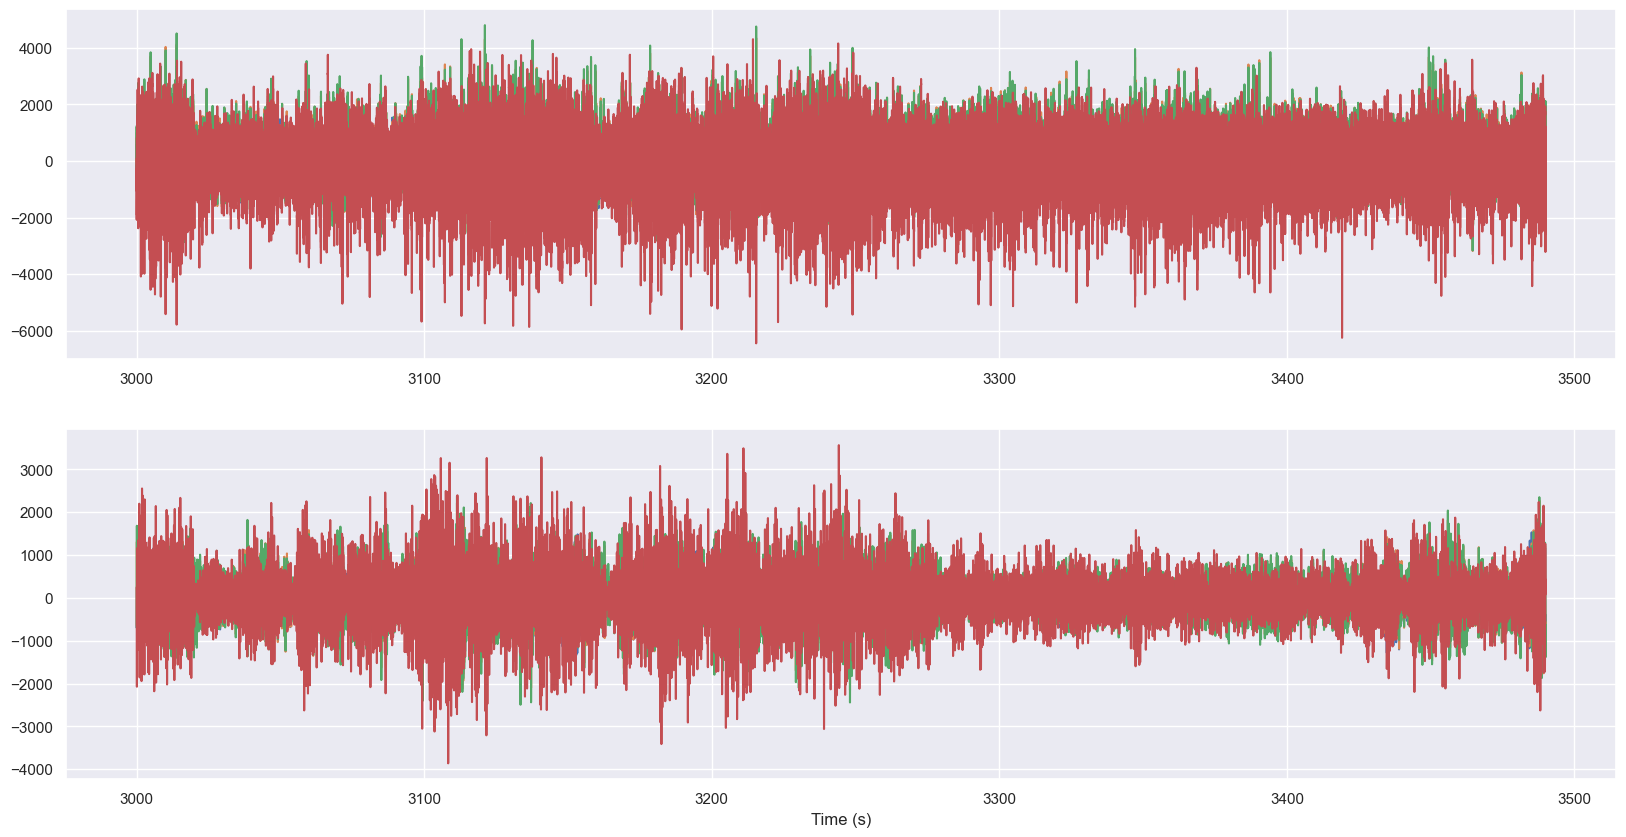

In [ ]:
signal = pyna.eeg_processing.bandpass_filter(lfpNREM, 3, 7, frequency)

figure(figsize=(20,10))
subplot(211)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(212)
plot(signal.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

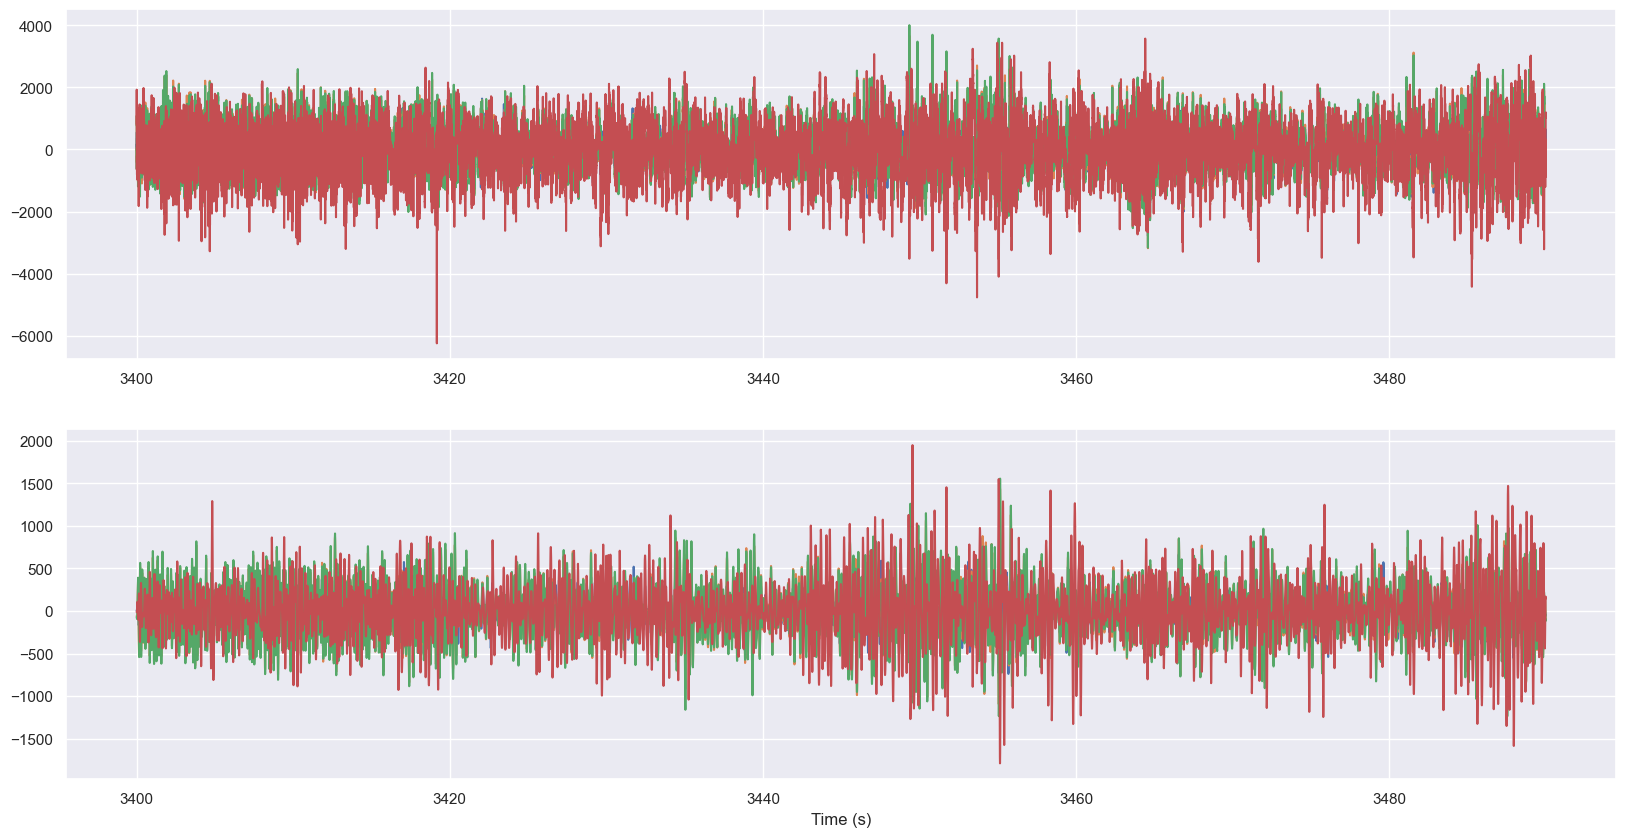

In [ ]:
signal = lowpass_filter(lfpNREM, 7, frequency)
signal = highpass_filter(signal, 3, frequency)

figure(figsize=(20,10))
subplot(211)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(212)
plot(signal.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

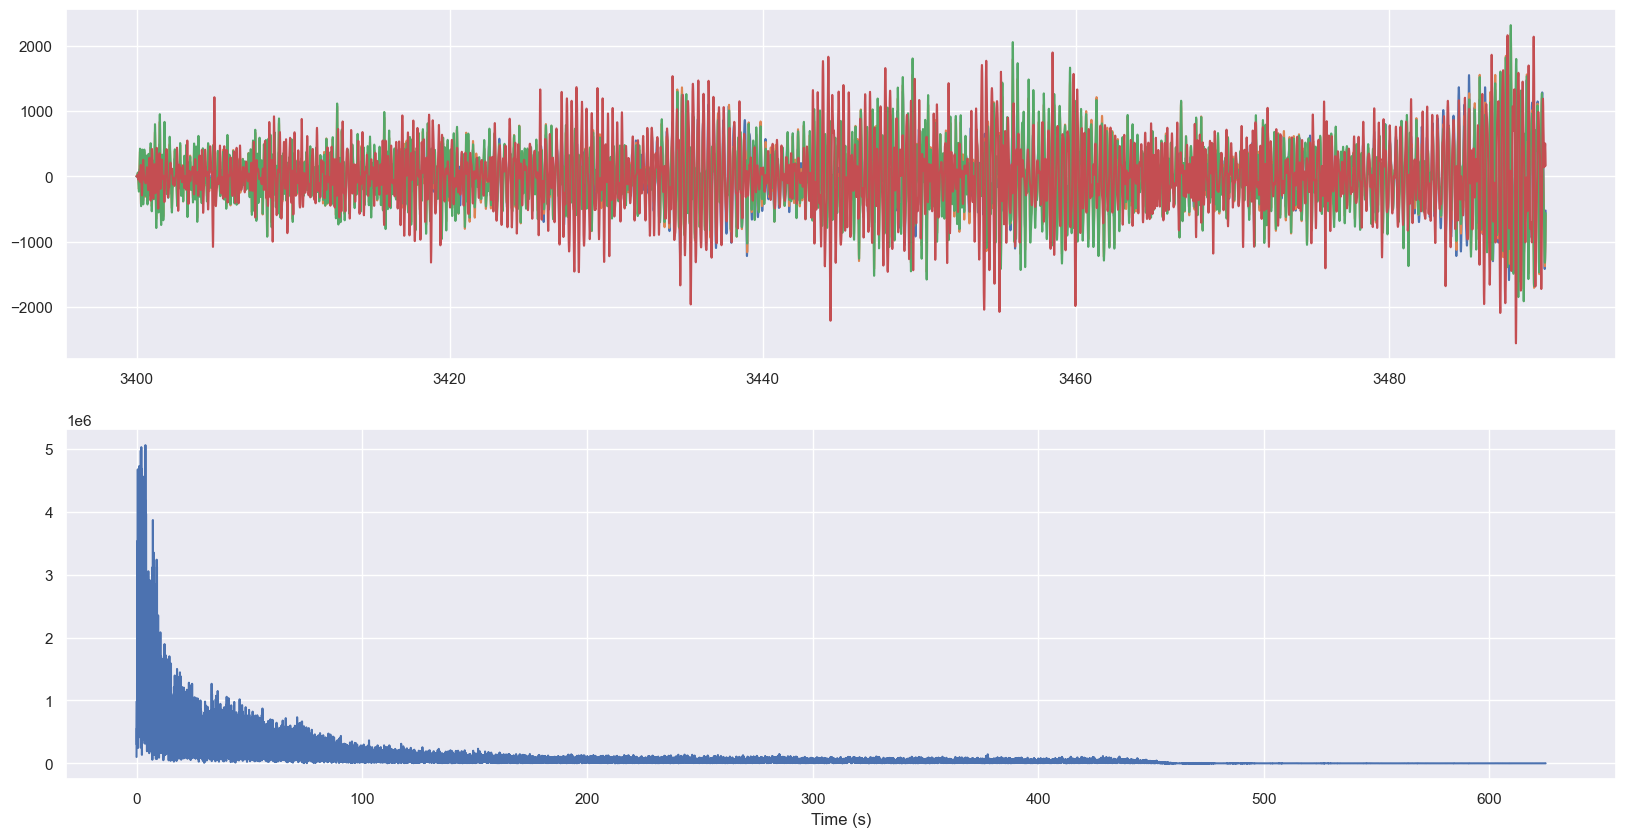

In [ ]:
freqFFT, fftValue = fft_transform(lfpNREM, samplingFreqLFP)
tmp = np.zeros([np.ceil(lfpNREM.shape[0]/2).astype(int),lfpNREM.shape[1]])

fftValue2=[]
for i in range(len(fftValue)):
    fftValue2.append(fftValue[i])

figure(figsize=(20,10))
subplot(211)
plot(signal.restrict(exEp).as_units('s'))
subplot(212)
plot(freqFFT, fftValue[-1])
xlabel("Time (s)")
show()

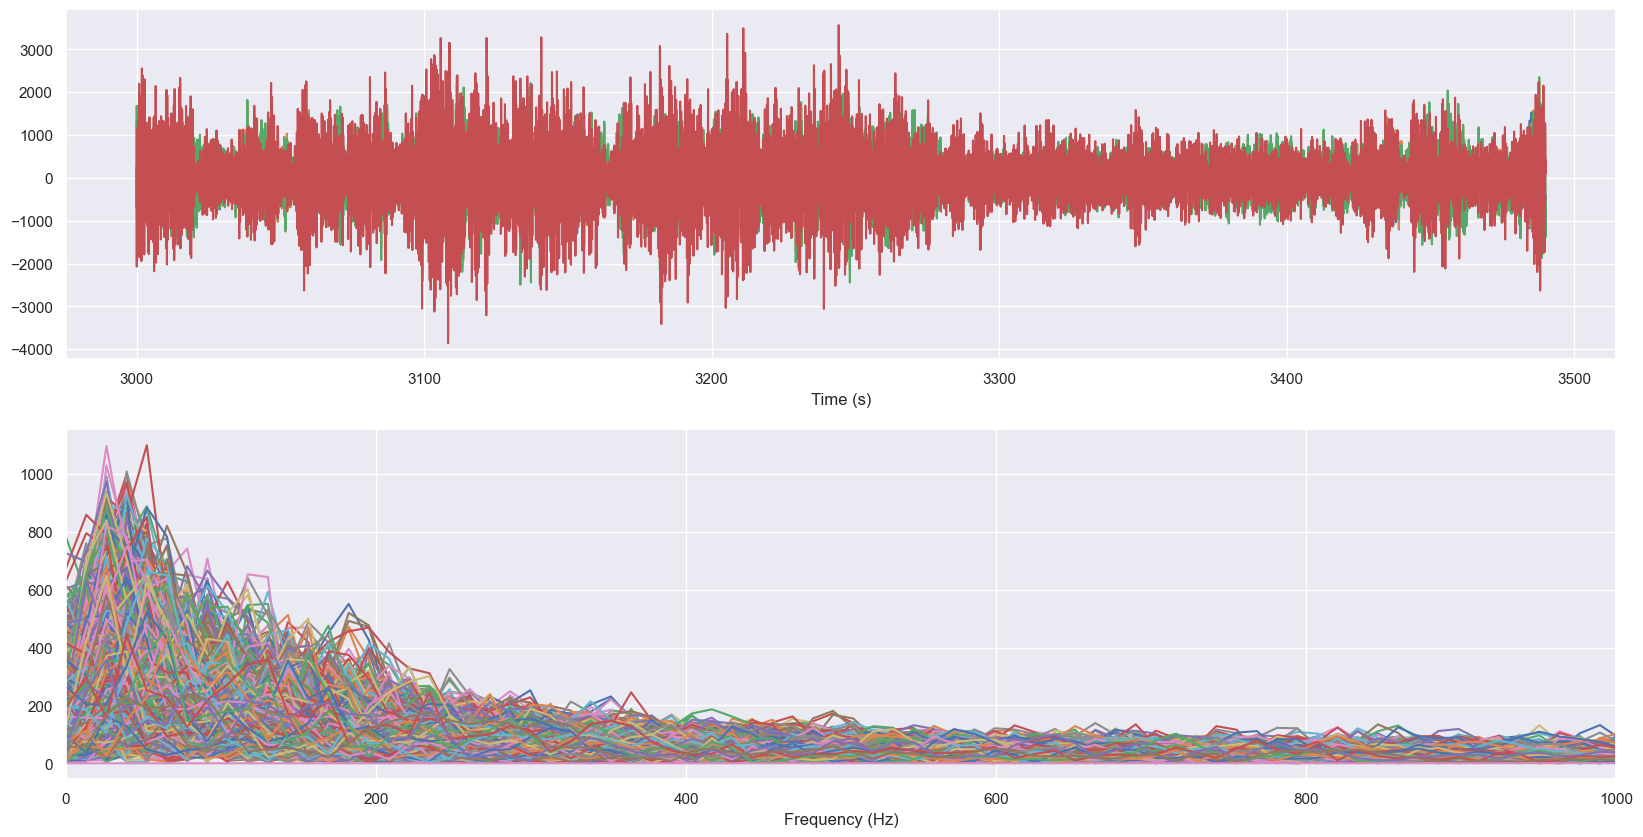

In [ ]:
windowSTFT=256*6
freqSTFT, tSTFT, stftValue = stft_transform(lfpNREM, samplingFreqWD, nperseg=windowSTFT)
tmp = np.zeros([np.ceil(lfpNREM.shape[0]/2).astype(int),lfpNREM.shape[1]])

stftValue2=[]
for i in range(len(stftValue)):
    stftValue2.append(stftValue[i])

figure(figsize=(20,10))
subplot(211)
plot(signal.restrict(exEp).as_units('s'))
xlabel('Time (s)')
subplot(212)
plot(freqSTFT, stftValue[-1])
xlabel('Frequency (Hz)')
xlim([0,1000])
show()

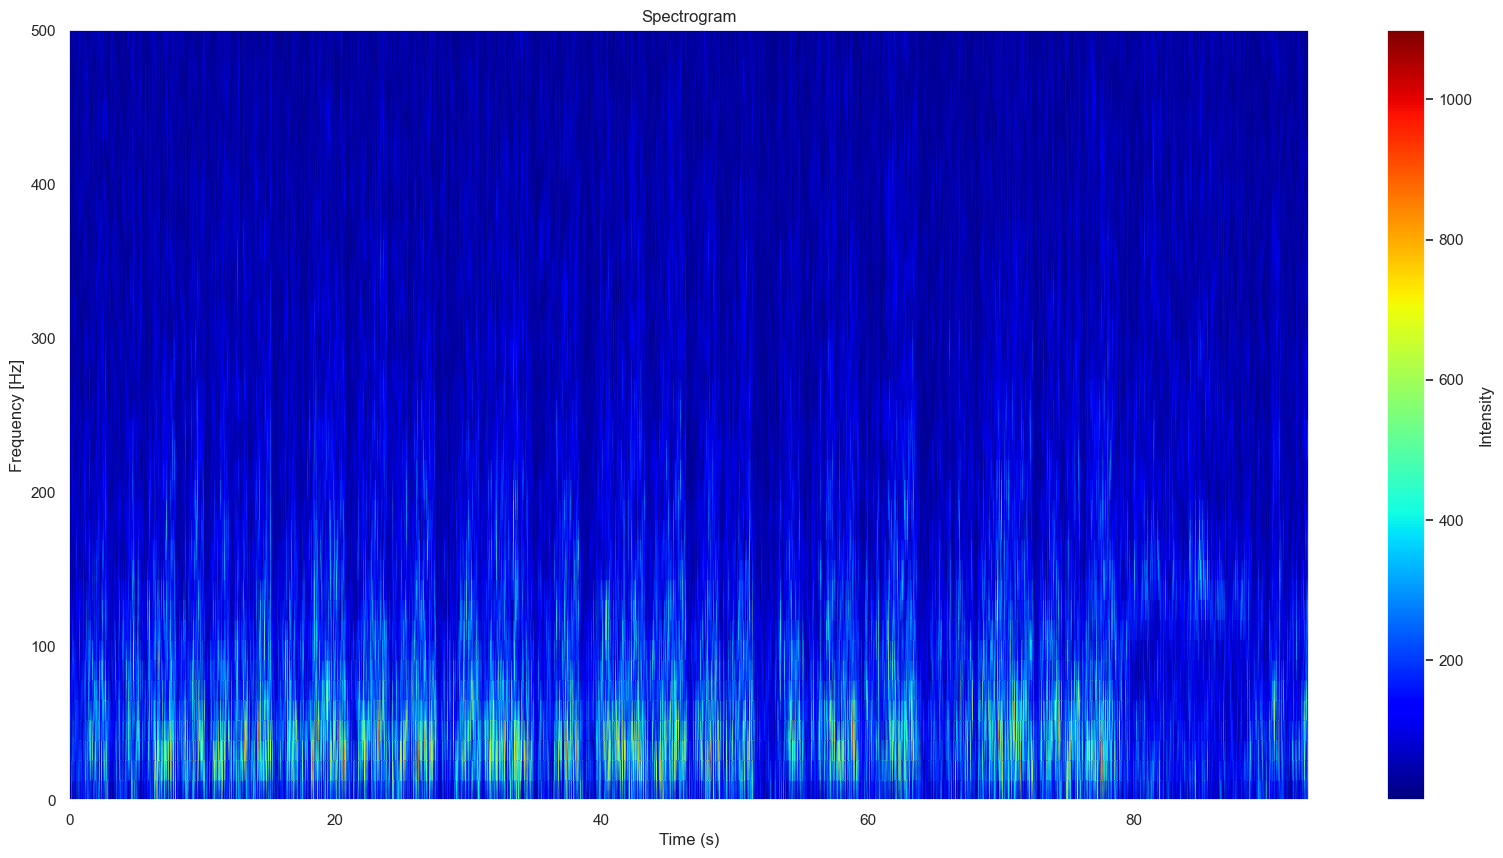

In [ ]:
magnitudeSpectrogram = np.abs(stftValue)

magnitudeSpectrogram = magnitudeSpectrogram

# Plot the spectrogram
plt.figure(figsize=(20, 10))
plt.pcolormesh(tSTFT, freqSTFT, magnitudeSpectrogram[3], shading='gouraud', cmap='jet')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time (s)')
plt.ylim([0, 500])
plt.colorbar(label='Intensity')

# Find the index of the maximum frequency based on intensity for each time slice
max_freq_indices = np.argmax(magnitudeSpectrogram, axis=0)
max_frequencies = freqSTFT[max_freq_indices]

# Overlay the maximum frequency plot
plt.plot(tSTFT, max_frequencies, color='white', linestyle='-', linewidth=2, label='Max Frequency')

plt.legend()
plt.show()

In [ ]:
# Use the Gaussian spectrogram transform function on your data
freqs_spect, times_spect, power_values_spect = gaussian_spectrogram_transform(lfpNREM, window_dur=0.01)

In [ ]:
coif = np.linspace(freqs_spect.min(), freqs_spect.max(), len(times_spect))

# Normalize the data for better visualization
norm = Normalize(vmin=np.min(power_values_spect[0]), vmax=np.max(power_values_spect[0]))

# Call the spectrogram_plot function to plot the spectrogram with the provided format
ax = spectrogram_plot(power_values_spect[0], times_spect, freqs_spect, coif, cmap='jet', norm=norm, colorbar=True)

# Adjust plot limits and labels as needed
ax.set_ylim(0, 50)  # Adjust the frequency limit
ax.set_title('Gaussian-windowed Spectrogram')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
plt.colorbar(ax.collections[0], label='Intensity (dB)', ax=ax)  # Add a colorbar with a label

plt.show()

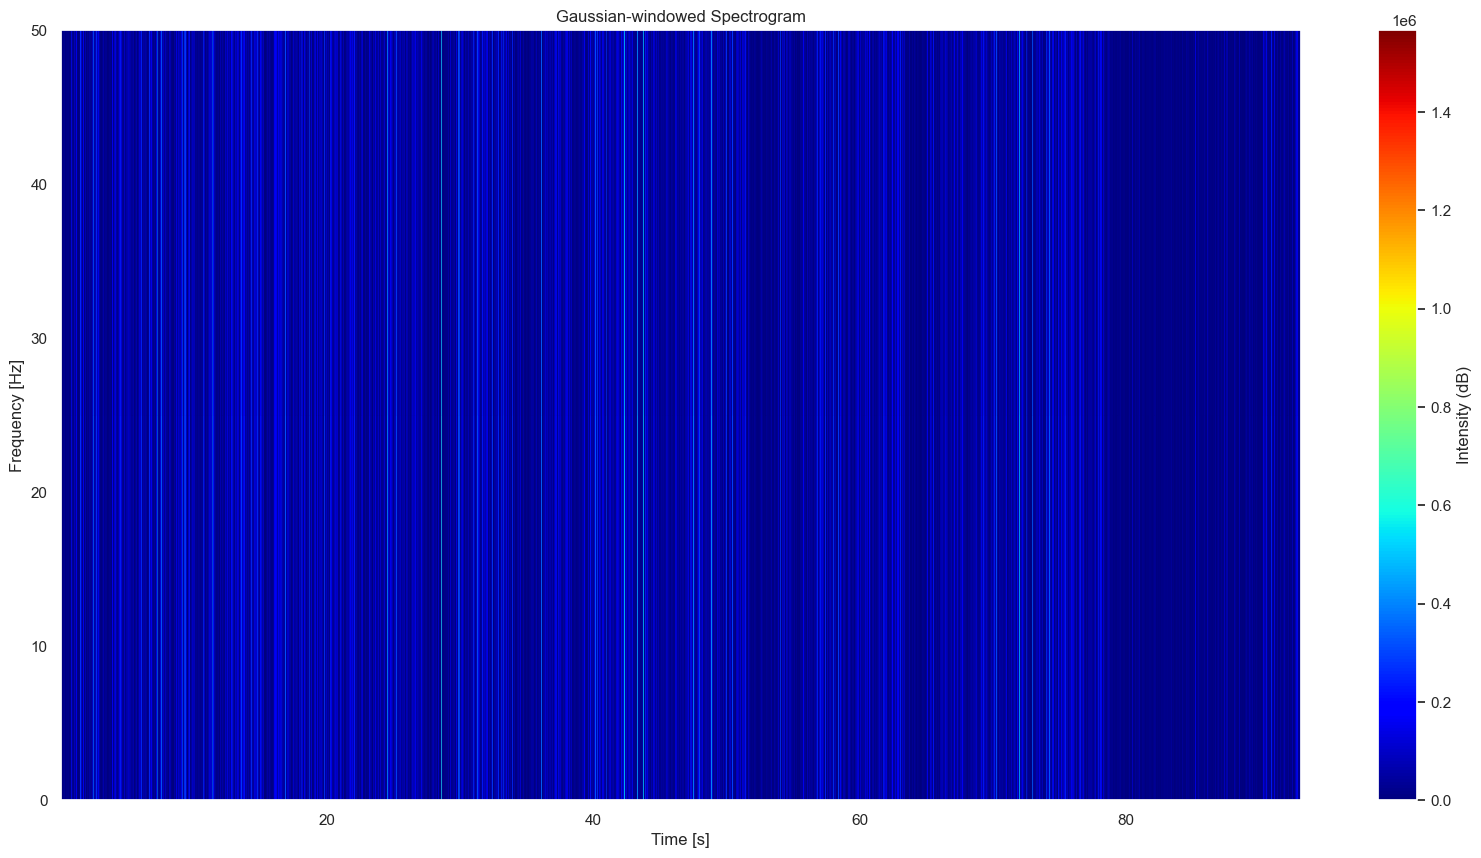

In [ ]:
# Plot the spectrogram
plt.figure(figsize=(20, 10))
plt.pcolormesh(times_spect, freqs_spect, power_values_spect[0], shading='gouraud', cmap='jet')
plt.title('Gaussian-windowed Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 50])  # Adjust this limit based on the frequency content of your data
plt.colorbar(label='Intensity (dB)')
plt.show()

In [ ]:
power_values_cwt, times_cwt, freqs_cwt, coif_cwt = cwt_spectrogram_transform(lfpNREM)

In [ ]:
# Plot the CWT spectrogram
plt.figure(figsize=(20, 10))
plt.pcolormesh(times_cwt, freqs_cwt, np.abs(power_values_cwt[0]), shading='gouraud', cmap='jet')  # Use absolute value for power
plt.title('Continuous Wavelet Transform Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 50])  # Adjust this limit based on the frequency content of your data
plt.colorbar(label='Intensity')
plt.show()

NameError: name 'times_cwt' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
signalFFT = fft_transform(lfpNREM, samplingFreqLFP)

figure(figsize=(20,10))
subplot(211)
plot(signal.restrict(exEp).as_units('s'))
subplot(212)
plot(signalFFT.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

In [ ]:
windowLength = 51

squaredSignal = np.square(signal.values)
window = np.ones(windowLength)/windowLength
nSS = filtfilt(window, 1, squaredSignal)
nSS = (nSS - np.mean(nSS))/np.std(nSS)
nSS = nap.Tsd(t=signal.index.values, 
              d=nSS, 
              time_support=signal.time_support)
              

figure(figsize=(15,5))
subplot(311)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(312)
plot(signal.restrict(exEp).as_units('s'))
subplot(313)
plot(nSS.restrict(exEp).as_units('s'))
xlabel("Time (s)")
tight_layout()
show()

## Mean signal

In [ ]:
frequency=samplingFreqLFP

lfpAll = data.load_lfp(channel=list(shanks[0][0]),extension='.eeg',frequency=frequency)

In [ ]:
#lfpNREMAll = lfpAll.restrict(nremEp)
lfpNREMAll = lfpAll.restrict(sampleEpoch)

figure(figsize=(15,5))
subplot(211)
plot(lfpNREMAll.as_units('s'))
subplot(212)
plot(lfpNREMAll.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

In [ ]:
signalAll = pyna.eeg_processing.bandpass_filter(lfpNREMAll, 250, 300, frequency)

figure(figsize=(15,5))
subplot(211)
plot(lfpNREMAll.restrict(exEp).as_units('s'))
subplot(212)
plot(signalAll.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

signalAll

In [ ]:
meanLFP = nap.Tsd(t=lfpNREMAll.index.values, 
              d=np.mean(lfpNREMAll.values, axis=1), 
              time_support=lfpNREMAll.time_support)

stdLFP = nap.Tsd(t=lfpNREMAll.index.values, 
              d=np.std(lfpNREMAll.values, axis=1), 
              time_support=lfpNREMAll.time_support)

meanSignal = nap.Tsd(t=signalAll.index.values, 
              d=np.mean(signalAll.values, axis=1), 
              time_support=signalAll.time_support)

stdSignal = nap.Tsd(t=signalAll.index.values, 
              d=np.std(signalAll.values, axis=1), 
              time_support=signalAll.time_support)

figure(figsize=(40,20))
subplot(411)
plot(lfpNREMAll.restrict(exEp).as_units('s'))
subplot(412)
plot(meanLFP.restrict(exEp).as_units('s'), linewidth=1)
plt.errorbar(meanLFP.restrict(exEp).t,meanLFP.restrict(exEp).d, yerr=stdLFP.restrict(exEp).d, ecolor='red', capsize=5, capthick=1, linestyle='-', color='blue',linewidth=0.5, label='Mean with variation')
subplot(413)
plot(signalAll.restrict(exEp).as_units('s'))
subplot(414)
plot(meanSignal.restrict(exEp).as_units('s'))
#plt.fill_between(meanSignal.restrict(exEp).as_units('s') - stdSignal.restrict(exEp).as_units('s'), meanSignal.restrict(exEp).as_units('s') + stdSignal.restrict(exEp).as_units('s'), alpha=0.2)
xlabel("Time (s)")
show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplot, plot, xlabel, show

# Assuming lfpNREMAll and signalAll are already defined

# Calculate mean and standard deviation for LFP
meanLFP = nap.Tsd(t=lfpNREMAll.index.values, 
                  d=np.mean(lfpNREMAll.values, axis=1), 
                  time_support=lfpNREMAll.time_support)
stdLFP = np.std(lfpNREMAll.values, axis=1)

# Calculate mean and standard deviation for Signal
meanSignal = nap.Tsd(t=signalAll.index.values, 
                     d=np.mean(signalAll.values, axis=1), 
                     time_support=signalAll.time_support)
stdSignal = np.std(signalAll.values, axis=1)

# Plotting
figure(figsize=(30, 10))

# Plot LFP
subplot(411)
plot(lfpNREMAll.restrict(exEp).as_units('s').index.values, lfpNREMAll.restrict(exEp).as_units('s').values)
subplot(412)
t_values = meanLFP.restrict(exEp).as_units('s').index.values
mean_values = meanLFP.restrict(exEp).as_units('s').values
plot(t_values, mean_values)
plt.fill_between(t_values, mean_values - stdLFP, mean_values + stdLFP, alpha=0.2)

# Plot Signal
subplot(413)
plot(signalAll.restrict(exEp).as_units('s').index.values, signalAll.restrict(exEp).as_units('s').values)
subplot(414)
t_values_signal = meanSignal.restrict(exEp).as_units('s').index.values
mean_values_signal = meanSignal.restrict(exEp).as_units('s').values
plot(t_values_signal, mean_values_signal)
plt.fill_between(t_values_signal, mean_values_signal - stdSignal, mean_values_signal + stdSignal, alpha=0.2)

xlabel("Time (s)")
show()


## State analysis

### Sleep state analysis based on a threshold of the mean signal

In [ ]:
def find_intervals(meanLFP, thresholdSleepState=10000):
    # Convert meanLFP.t and meanLFP.d into a DataFrame
    df = pd.DataFrame({'Time': meanLFP.t, 'Value': meanLFP.d})

    # Classify each time point as sleep or wake based on the threshold
    df['State'] = np.where(df['Value'] > thresholdSleepState, 'Wake', 'Sleep')

    # Identify changes in state
    df['StateChange'] = df['State'].ne(df['State'].shift())
    df['IntervalStart'] = df['Time'].where(df['StateChange'])

    # Forward fill the interval starts to label all rows with their interval's start
    df['IntervalStart'].ffill(inplace=True)

    # Initialize a dictionary to store intervals by state
    intervalSleepState = {}

    # Separate intervals by state and store in the dictionary
    for state in df['State'].unique():
        intervals = df[df['State'] == state].groupby(['State', 'IntervalStart']).agg(StartTime=('Time', 'min'), EndTime=('Time', 'max')).reset_index(drop=True)
        intervalSleepState[state] = intervals[['StartTime', 'EndTime']]

    return intervalSleepState
    
thresholdSleepState = 4000
intervalSleepState = find_intervals(meanLFP, thresholdSleepState)

intervalSleepState

In [ ]:
import matplotlib.patches as mpatches

# Assuming intervalSleepState is correctly defined before this
fig, ax = plt.subplots(figsize=(12, 4))

def plot_state_intervals(stateArray, stateName, color, yPosition):
    global labelSleepState  # To modify the global variable within the function
    for interval in stateArray:
        start, end = interval
        width = end - start
        # Add label only if it hasn't been added before
        label = stateName if stateName not in labelSleepState else ""
        ax.barh(yPosition, width, left=start, color=color, edgecolor='black', height=0.8, label=label)
        if stateName not in labelSleepState:
            labelSleepState.append(stateName)  # Update the list to include the new label

labelSleepState = []  # Initialize outside the function to keep track of labels

# Plot each state with a different color and position
plot_state_intervals(np.array(intervalSleepState['Sleep']), 'Sleep', 'blue', 1)
plot_state_intervals(np.array(intervalSleepState['Wake']), 'Wake', 'orange', 2)

# Beautify the plot
ax.set_yticks([1, 2])
ax.set_yticklabels(['Sleep', 'Wake'])
ax.set_xlabel('Time (seconds)')
ax.set_title('Sleep States Over Time')
ax.set_ylim(0.5, 2.5)  # Adjusted to closely fit the plotted bars

# Since labelSleepState now correctly tracks unique state names, we directly create legend entries
sleep_patch = mpatches.Patch(color='blue', label='Sleep')
wake_patch = mpatches.Patch(color='orange', label='Wake')
ax.legend(handles=[sleep_patch, wake_patch], loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(right=0.8)  # Adjust the right margin to ensure legend fits
plt.show()

In [ ]:
import matplotlib.patches as mpatches
maxTime = max(df['EndTime'].max() for df in intervalSleepState.values())
numPlots = int(np.ceil(maxTime / 10000))

# Adjust for a single plot to avoid subplot indexing issues
fig, axs = plt.subplots(max(1, numPlots), figsize=(15, 2 * max(1, numPlots)), squeeze=False)
if numPlots == 1:
    axs = [axs]  # Make it iterable

def plot_state_intervals(ax, stateArray, stateName, color, yPosition, startTime, endTime):
    labelSet = set()  # To keep track of labels already added to this ax
    for interval in stateArray:
        if interval[1] < startTime or interval[0] > endTime:
            continue
        adjustedStart = interval[0]
        adjustedEnd = interval[1]
        width = adjustedEnd - adjustedStart
        # Add label only if not already added
        label = stateName if stateName not in labelSet else ""
        ax.barh(yPosition, width, left=adjustedStart, color=color, edgecolor='black', height=0.8, label=label)
        labelSet.add(stateName)

for i in range(max(1, numPlots)):
    startTime = i * 10000
    endTime = min((i + 1) * 10000, maxTime)
    ax = axs[i][0] if numPlots > 1 else axs[i]  # Adjust indexing based on number of plots
    
    plot_state_intervals(ax, np.array(intervalSleepState['Sleep']), 'Sleep', 'blue', 1, startTime, endTime)
    plot_state_intervals(ax, np.array(intervalSleepState['Wake']), 'Wake', 'orange', 2, startTime, endTime)

    ax.set_xlim(startTime, endTime)
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['Sleep', 'Wake'])
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'Time Range: {startTime} to {endTime} seconds')
    ax.set_ylim(0.5, 2.5)  # Adjust ylim to fit the two bars

    # Manually create legend to ensure it's added only once per subplot
    if i == 0:  # Assuming we want the legend only on the first plot for clarity
        sleep_patch = mpatches.Patch(color='blue', label='Sleep')
        wake_patch = mpatches.Patch(color='orange', label='Wake')
        ax.legend(handles=[sleep_patch, wake_patch], loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust right margin to accommodate legend if outside
plt.show()

### Sleep state analysis with the sleep state .mat file

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))

# Updated helper function for plotting state intervals as bars
def plot_state_intervals(stateArray, stateName, color, yPosition):
    for interval in stateArray:
        start, end = interval
        width = end - start
        ax.barh(yPosition, width, left=start, color=color, edgecolor='black', height=0.8, label=stateName if stateName not in labelSleepState else "")

labelSleepState = []  # Keep track of labels already added to legend

# Plot each state with a different color and position
plot_state_intervals(sleepStateInts['NREMstate'], 'NREM', 'blue', 1)
plot_state_intervals(sleepStateInts['REMstate'], 'REM', 'green', 2)
plot_state_intervals(sleepStateInts['WAKEstate'], 'WAKE', 'orange', 3)

# Beautify the plot
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['NREM', 'REM', 'WAKE'])
ax.set_xlabel('Time (seconds)')
ax.set_title('Sleep States Over Time')
ax.set_ylim(0.5, 3.5)

# Fixing the legend to show unique labels
handleSleepState, labelSleepState = plt.gca().get_legend_handles_labels()
byLabelSleepState = dict(zip(labelSleepState, handleSleepState))  # Removes duplicates
ax.legend(byLabelSleepState.values(), byLabelSleepState.keys(), loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

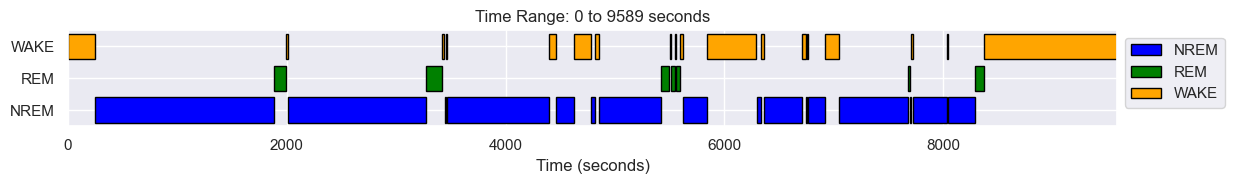

In [14]:
maxTime = max([interval[-1] for state in sleepStateInts for interval in state])
numPlots = np.ceil(maxTime / 10000).astype(int)

fig, axs = plt.subplots(numPlots, 1, figsize=(15, 2 * numPlots), squeeze=False)

def plot_state_intervals(ax, stateArray, stateName, color, yPosition, startTime, endTime):
    for interval in stateArray:
        if interval[1] < startTime or interval[0] > endTime:
            continue
        adjustedStart = interval[0]
        adjustedEnd = interval[1]
        width = adjustedEnd - adjustedStart
        ax.barh(yPosition, width, left=adjustedStart, color=color, edgecolor='black', height=0.8, label=stateName if stateName not in labelSleepState else "")

for i in range(numPlots):
    startTime = i * 10000
    endTime = min((i + 1) * 10000, maxTime)
    ax = axs[i, 0]
    labelSleepState = []

    plot_state_intervals(ax, sleepStateInts['NREMstate'], 'NREM', 'blue', 1, startTime, endTime)
    plot_state_intervals(ax, sleepStateInts['REMstate'], 'REM', 'green', 2, startTime, endTime)
    plot_state_intervals(ax, sleepStateInts['WAKEstate'], 'WAKE', 'orange', 3, startTime, endTime)

    ax.set_xlim(startTime, endTime)  # Adjust this line to reflect the actual timeline
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['NREM', 'REM', 'WAKE'])
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'Time Range: {startTime} to {endTime} seconds')
    ax.set_ylim(0.5, 3.5)

    handleSleepState, labelSleepState = ax.get_legend_handles_labels()
    byLabelSleepState = dict(zip(labelSleepState, handleSleepState))
    ax.legend(byLabelSleepState.values(), byLabelSleepState.keys(), loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

## Step-by-step detection of the UFO

In [15]:
sampleEpoch = nap.IntervalSet(start = 1000, end = 3500, time_units = 's') 

NameError: name 'exEp' is not defined

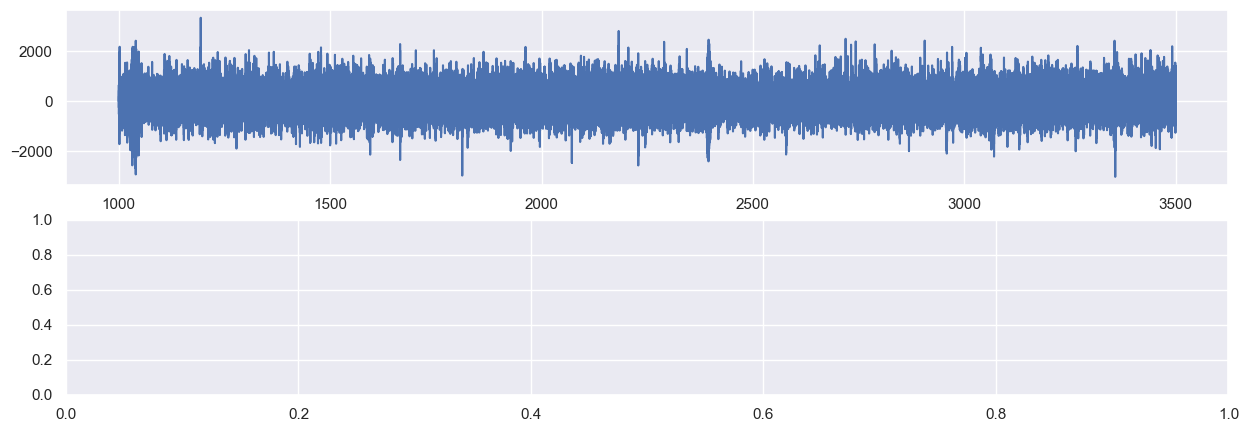

In [16]:
frequency=samplingFreqLFP

lfp = data.load_lfp(channel=29,extension='.eeg',frequency=frequency)
#lfp=meanSignal

#lfpNREMCh = lfp.restrict(nremEp)
lfpNREM = lfp.restrict(sampleEpoch)

figure(figsize=(15,5))
subplot(211)
plot(lfpNREM.as_units('s'))
subplot(212)
plot(lfpNREM.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

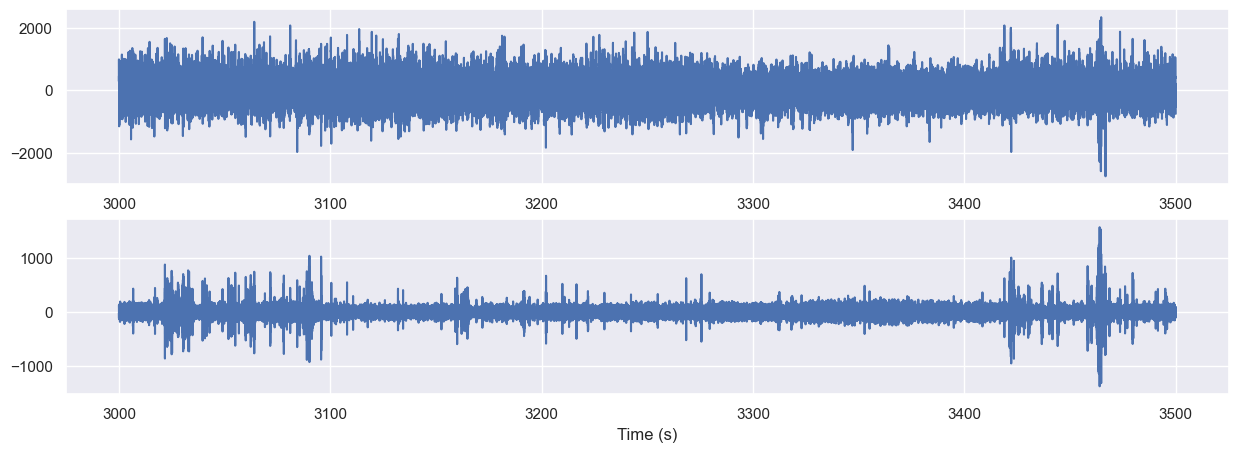

In [ ]:
signal = pyna.eeg_processing.bandpass_filter(lfpNREM, 200, 400, frequency)

figure(figsize=(15,5))
subplot(211)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(212)
plot(signal.restrict(exEp).as_units('s'))
xlabel("Time (s)")
show()

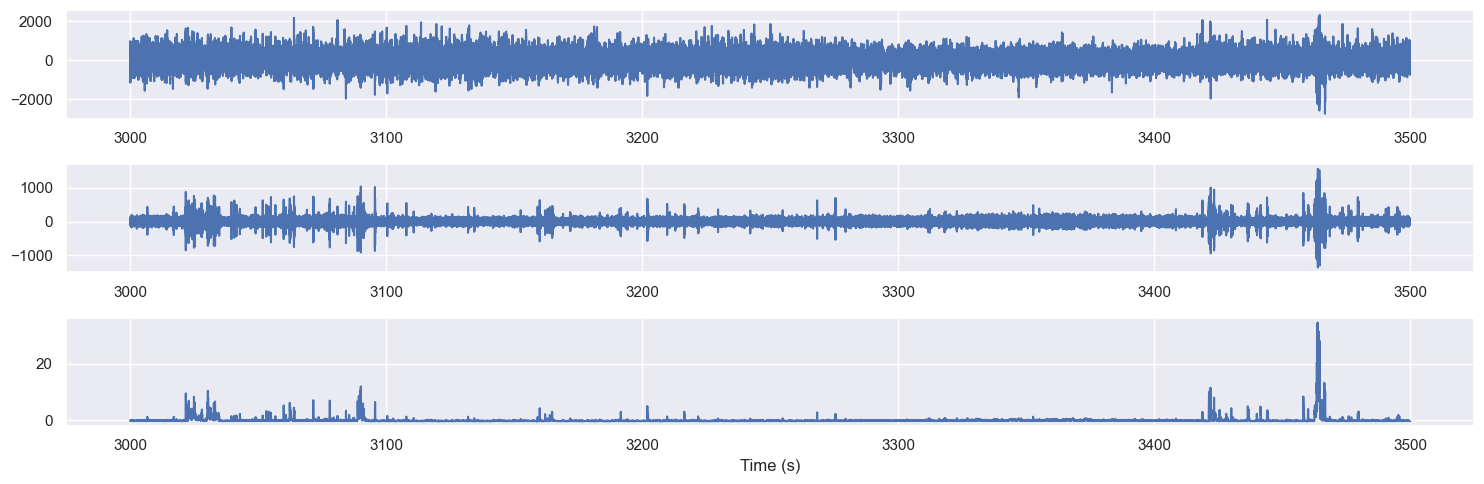

In [ ]:
windowLength = 51

squaredSignal = np.square(signal.values)
window = np.ones(windowLength)/windowLength
nSS = filtfilt(window, 1, squaredSignal)
nSS = (nSS - np.mean(nSS))/np.std(nSS)
nSS = nap.Tsd(t=signal.index.values, 
              d=nSS, 
              time_support=signal.time_support)
              

figure(figsize=(15,5))
subplot(311)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(312)
plot(signal.restrict(exEp).as_units('s'))
subplot(313)
plot(nSS.restrict(exEp).as_units('s'))
xlabel("Time (s)")
tight_layout()
show()

### Round 1 : Detecting Oscillation Periods by thresholding normalized signal

c:\Users\Rafael\.conda\envs\pynapple\lib\site-packages\pynapple\core\time_series.py:1610: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=ns, end=ne)


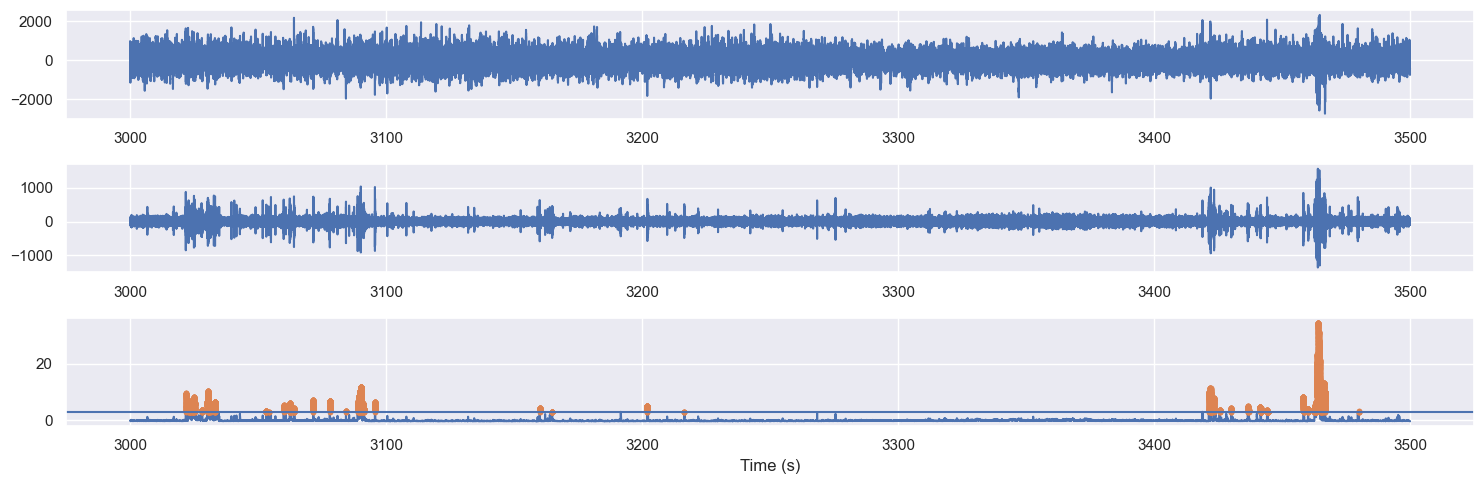

In [ ]:
highThres = 100
lowThres = 3


nSS2 = nSS.threshold(lowThres, method='above')
nSS3 = nSS2.threshold(highThres, method='below')

figure(figsize=(15,5))
subplot(311)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(312)
plot(signal.restrict(exEp).as_units('s'))
subplot(313)
plot(nSS.restrict(exEp).as_units('s'))
plot(nSS3.restrict(exEp).as_units('s'), '.')
axhline(lowThres)
xlabel("Time (s)")
tight_layout()
show()


In [ ]:
# Save for plotting in .npz
        nSS3_ufo.save(data.path + '\\'+ data.basename+'_nSS3.npz')
        nSS_ufo.save(data.path + '\\'+ data.basename+'_nSS.npz')
        signal_ufo.save(data.path + '\\'+ data.basename+'_signal.npz')
    else:
        sign_channels = channels[ufo_channels_nb[s][0]]
        nSS3_ufo=nap.load_file(data.path + '\\'+ data.basename+'_nSS3.npz')
        nSS_ufo=nap.load_file(data.path + '\\'+ data.basename+'_nSS.npz')
        signal_ufo=nap.load_file(data.path + '\\'+ data.basename+'_signal.npz')

### Round 2 : Excluding oscillation whose length < min_duration and greater than max_duration

In [ ]:
minUFOLen = 10 # ms
maxUFOLen = 1000 # ms

ufoEp = nSS3.time_support
ufoEp = ufoEp.drop_short_intervals(minUFOLen, time_units = 'ms')
ufoEp = ufoEp.drop_long_intervals(maxUFOLen, time_units = 'ms')

### Round 3 : Merging oscillation if inter-oscillation period is too short

In [ ]:
minInterRippleInterval = 0 # ms
ufoEp = ufoEp.merge_close_intervals(minInterRippleInterval, time_units = 'ms')
ufoEp = ufoEp.reset_index(drop=True)

### Round 4: Extracting Oscillation peak

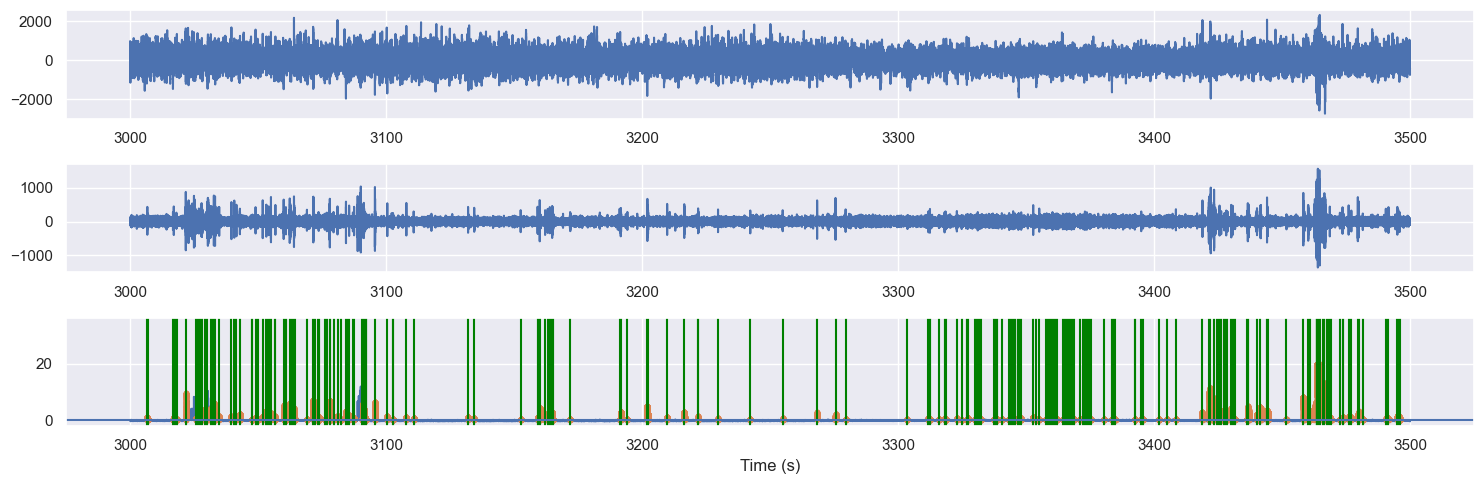

Time (s)
----------  --------
1000.8848   0.823312
1007.3072   0.459019
1007.4176   0.394014
1008.1184   0.770544
1010.6728   0.70039
...
3495.2944   0.600732
3495.3888   1.91629
3495.5176   0.490079
3495.8424   1.39226
3495.9608   0.302762
dtype: float64, shape: (1274,)

In [ ]:
ufoMax = []
ufoTsd = []
for i in range(len(ufoEp)):
    s,e=ufoEp.loc[i]
    tmp = nSS[np.argmin(np.abs(nSS.t - s)):np.argmin(np.abs(nSS.t - e))]
    ufoTsd.append(tmp.t[np.argmax(tmp)])
    ufoMax.append(np.max(tmp))

ufoMax = np.array(ufoMax)
ufoTsd = np.array(ufoTsd)

ufoTsd = nap.Tsd(t=ufoTsd, d=ufoMax, time_support=nremEp)

figure(figsize=(15,5))
subplot(311)
plot(lfpNREM.restrict(exEp).as_units('s'))
subplot(312)
plot(signal.restrict(exEp).as_units('s'))
subplot(313)
plot(nSS.restrict(exEp).as_units('s'))
plot(nSS3.restrict(ufoEp.intersect(exEp)).as_units('s'), '.')
[axvline(t, color = 'green') for t in ufoTsd.restrict(exEp).as_units('s').index.values]
axhline(lowThres)
xlabel("Time (s)")
tight_layout()
show()

ufoTsd

## Pynapple functions to detect UFO

In [ ]:
lfp = data.load_lfp(channel=29,extension='.eeg',frequency=1250.0)
ufoEp, ufoTsd= pyna.eeg_processing.detect_oscillatory_events(
                                            lfp = lfp,
                                            epoch = sampleEpoch,
                                            freq_band = (200,400),
                                            thres_band = (1,20),
                                            duration_band = (0,1),
                                            min_inter_duration = 0
                                            )

ufoTsd

c:\Users\Rafael\.conda\envs\pynapple\lib\site-packages\pynapple\core\time_series.py:1610: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=ns, end=ne)


Time (s)
----------  -------
2000.548    1.18376
2007.2984   4.24523
2009.9192   1.10342
2010.4576   1.75999
2010.9496   1.46209
...
3485.1736   1.62792
3487.9496   2.20729
3488.8176   1.8544
3489.3056   2.32305
3489.8728   1.28534
dtype: float64, shape: (1548,)

In [ ]:
data.write_neuroscope_intervals(extension='.evt.rip', isets=ufoEp, name='UFO')

In [ ]:
data.save_nwb_intervals(ufoEp, 'ufo')
data.save_nwb_timeseries(ufoTsd, 'ufo')

## Peri-Event Time Histogram

In [ ]:
spikes

In [ ]:
peth16 = nap.compute_perievent(spikes[29], ufoTsd, minmax=(-300, 300), time_unit='ms')

peth16[list(range(5))] # showing only the first five events

In [ ]:
peth16.time_support

In [ ]:
peth16.set_info(ufo_power = ufoTsd.values)
print(peth16[list(range(5))])

In [ ]:
peth16_2 = peth16.getby_threshold('ufo_power', 0.2)
peth16_2

In [ ]:
ufoCt16 = peth16_2.count(0.01).as_units('s').mean(1)

## Raster plot

In [ ]:
figure(figsize = (18, 8))

subplot(211)
plot(ufoCt16)
subplot(212)
for event in peth16_2.keys():
    plot(peth16_2[event].as_units('s').fillna(event), '|')
xlabel("Time from UFO event (s)")
show()

In [ ]:
spikesMEC = spikes.getby_category('location')['AD']
pethMEC = nap.compute_perievent(spikesMEC, ufoTsd, minmax=100, time_unit='ms')

meanFrMEC = {}
for n in pethMEC.keys():
    meanFrMEC[n] = pethMEC[n].count(0.01, time_units = 's').as_units('s').mean(1)

meanFrMEC = pd.DataFrame.from_dict(meanFrMEC)

meanFrMEC

In [ ]:
figure(figsize = (18, 8))

subplot(111)
plot(meanFrMEC)
plot(meanFrMEC.mean(1), linewidth = 4)
xlabel("Time from ripple event (s)")
show()